# Interface with gammapy

This notebook demonstrates how you can easily set up a model for `gammapy` that interfaces with the `OptDepth` class from `ebltable`.
For this notebook to run, you need to have `gammapy` installed. I tested the notebook with `gammapy` version 1.0.

We start with the necessary `gammapy` imports.

In [1]:
from gammapy.modeling.models import TemplateSpectralModel, SpectralModel
from gammapy.modeling import Parameter

And continue with addtional imports. 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from astropy import units as u
from ebltable.tau_from_model import OptDepth

Then we pick an EBL model in initialize the `OptDepth` class. For illustration we also set up a `gammapy` template spectrum. For this, it's however not possible to change the EBL normalization parameter.

In [3]:
ebl_model = 'finke2022'

In [4]:
tau =  OptDepth.readmodel(model=ebl_model)

In [5]:
z = 0.2
ETeV = np.logspace(-1,1.5,50)

In [6]:
atten = np.exp(-1. * tau.opt_depth(z,ETeV))

In [7]:
template = TemplateSpectralModel(energy=ETeV * u.TeV, values=atten)

Now we build our own spectral model class. The class has the possibility to be initiated from a built-in model.

In [8]:
class OptDepthSpectralModel(SpectralModel):
    
    r"""Gamma-ray absorption models build from the `~ebltable` package. 
    
    Parameters
    ----------
    optdepth : `~ebltable.tau_from_model.OptDepth`
        optical depth class
    redshift : float
        Redshift of the absorption model
    alpha_norm: float
        Norm of the EBL model
    """

    tag = ["OptDepthSpectralModel", "tau-norm"]
    alpha_norm = Parameter("alpha_norm", 1.0, frozen=True)
    redshift = Parameter("redshift", 0.1, frozen=True)

    def __init__(self, optdepth, redshift, alpha_norm):
        self.optdepth = optdepth
        self._cashed_redshift = None
        self._cashed_tau = None
        
        super().__init__(redshift=redshift, alpha_norm=alpha_norm)

    @classmethod
    def read_model(cls, model, redshift, alpha_norm=1.):
        """
        Initiate the class from a built-in model 
        
        Parameters
        ----------
        model: str
            model name implemented in `ebltable.tau_from_model.OptDepth`
        
        redshift: float
            source redshift
        """
        optdepth = OptDepth.readmodel(model=model)
        
        return cls(
            optdepth=optdepth,
            redshift=redshift,
            alpha_norm=alpha_norm,
        )

    def evaluate(self, energy, redshift, alpha_norm):
        """Evaluate model for energy and parameter value."""
        if self._cashed_redshift is None \
            or not self._cashed_redshift == redshift:
            
            try: 
                self._cashed_tau = self.optdepth.opt_depth(redshift.value, energy.to(u.TeV).value)
            except AttributeError:
                self._cashed_tau = self.optdepth.opt_depth(redshift, energy.to(u.TeV).value)
        
        absorption = np.exp(-self._cashed_tau * alpha_norm)
        return absorption

Initialize the class from a built-in model is done in the following way:

In [9]:
optdepth = OptDepthSpectralModel.read_model(ebl_model, z)

Here are the parameters of the model:

In [10]:
optdepth.parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str10,float64,str1,int64,float64,float64,bool,bool,str1
spectral,alpha_norm,1.0000e+00,,0.000e+00,nan,nan,True,False,
spectral,redshift,2.0000e-01,,0.000e+00,nan,nan,True,False,


Lastly, we plot everything for comparison. 

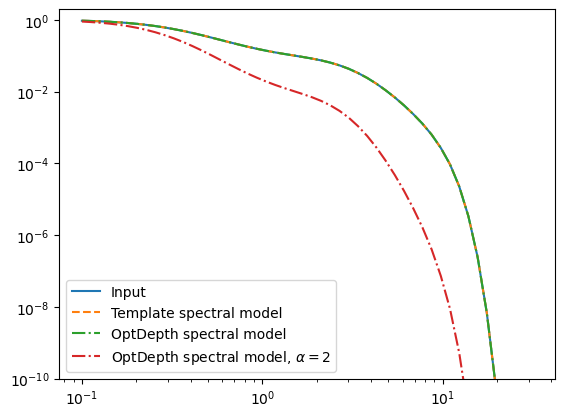

In [11]:
plt.loglog(ETeV, atten, label="Input")
plt.loglog(ETeV, template(ETeV * u.TeV), ls='--', label="Template spectral model")
plt.loglog(ETeV, optdepth(ETeV * u.TeV), ls='-.', label="OptDepth spectral model")
plt.loglog(ETeV, optdepth.evaluate(ETeV * u.TeV, z, 2.), ls='-.', label=r"OptDepth spectral model, $\alpha = 2$")
plt.ylim(1e-10, 2.)
plt.legend()

Now, you can use the `OptDepthSpectralModel` within a `gammapy` `CompoundSpectralModel` to fit the EBL normalization `alpha_norm` (or the source redshift) together with the intrinsic spectral parameters to your favorite blazar observation.